# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [ ]:
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import plotly.express as px

import seaborn as sns

# import Kmeans from sklearn
from sklearn.cluster import KMeans

#Scalar
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

import plotly.graph_objects as go

import requests 
from IPython.display import JSON
import json

import warnings
warnings.filterwarnings("ignore")

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

In [ ]:
df_flights = pd.read_csv('flights_db_training_data')
df_flights.info()

In [ ]:
df_flights[['origin_city', 'origin_state']]= df_flights['origin_city_name'].str.split(',',
                                                                                expand=True)
df_flights[['dest_city', 'dest_state']]= df_flights['dest_city_name'].str.split(',',
                                                                                expand=True)
df_flights

In [498]:
df_flights_feat = df_flights.copy()

In [ ]:
url = 'https://api.worldweatheronline.com/premium/v1/past-weather.ashx'

df_weather_dep = pd.DataFrame()

df_weather_arr = pd.DataFrame()

df_weather_data = pd.DataFrame()

i = 0

#key = 'c0608014bbb545748f6132037232201'

key = '7702f260caf2429eac441552232202'
formatting = 'json'
tp = '6'

for index, row in df_flights_feat.iterrows():
    params_dep = {'date': str(row['fl_date']), 'q': str(row['origin_city']) + ',' + str(row['origin_state']), 
                          'tp': tp, 'key': key, 'format': formatting}

    res_weather_dep = requests.get(url, headers={'accept': 'application/JSON'}, params=params_dep)

    df_weather_dep = pd.json_normalize(res_weather_dep.json(), 
                                        record_path = ['data', 'weather', 'hourly', 'weatherDesc'],
                                        meta = [
                                                ['data', 'weather', 'hourly','tempC'],
                                                ['data', 'weather', 'hourly','windspeedMiles'],
                                                ['data', 'weather', 'hourly','winddir16Point'],
                                                ['data', 'weather', 'hourly','WindGustMiles'],
                                                ['data', 'weather', 'hourly','WindChillC'],
                                                ['data', 'weather', 'hourly','precipInches'],
                                                ['data', 'weather', 'hourly','humidity'],
                                                ['data', 'weather', 'hourly','visibilityMiles'],
                                                ['data', 'weather', 'hourly','pressureInches'],
                                                ['data', 'weather', 'hourly','DewPointC'],
                                                ['data', 'weather', 'hourly','cloudcover'],
                                                ['data', 'weather', 'hourly','uvIndex']
                                               ]
                                      )
    
    res_temp_dep = res_weather_dep.json()
    
    df_weather_dep['totalSnow_cm'] = res_temp_dep['data']['weather'][0]['totalSnow_cm']
    
    params_arr = {'date': str(row['fl_date']), 'q': str(row['dest_city']) + ',' + str(row['dest_state']), 
                          'tp': tp, 'key': key, 'format': formatting}

    res_weather_arr = requests.get(url, headers={'accept': 'application/JSON'}, params=params_arr)

    df_weather_arr = pd.json_normalize(res_weather_arr.json(), 
                                        record_path = ['data', 'weather', 'hourly', 'weatherDesc'],
                                        meta = [
                                                ['data', 'weather', 'hourly','tempC'],
                                                ['data', 'weather', 'hourly','windspeedMiles'],
                                                ['data', 'weather', 'hourly','winddir16Point'],
                                                ['data', 'weather', 'hourly','WindGustMiles'],
                                                ['data', 'weather', 'hourly','WindChillC'],
                                                ['data', 'weather', 'hourly','precipInches'],
                                                ['data', 'weather', 'hourly','humidity'],
                                                ['data', 'weather', 'hourly','visibilityMiles'],
                                                ['data', 'weather', 'hourly','pressureInches'],
                                                ['data', 'weather', 'hourly','DewPointC'],
                                                ['data', 'weather', 'hourly','cloudcover'],
                                                ['data', 'weather', 'hourly','uvIndex'],
                                                ['data', 'weather','totalSnow_cm']
                                               ]
                                      )
    
    res_temp_arr = res_weather_arr.json()
    
    df_weather_arr['totalSnow_cm'] = res_temp_arr['data']['weather'][0]['totalSnow_cm']
    
    if row['crs_dep_time'] in range (0, 600):
        df_weather_data.at[i, 'origin_weather_condn']= df_weather_dep.iloc[0][0]
        df_weather_data.at[i, 'origin_tempC']= df_weather_dep.iloc[0][1]
        df_weather_data.at[i, 'origin_windspeedMiles']= df_weather_dep.iloc[0][2]
        df_weather_data.at[i, 'origin_winddir16Point']= df_weather_dep.iloc[0][3]
        df_weather_data.at[i, 'origin_WindGustMiles']= df_weather_dep.iloc[0][4]
        df_weather_data.at[i, 'origin_WindChillC']= df_weather_dep.iloc[0][5]
        df_weather_data.at[i, 'origin_precipInches']= df_weather_dep.iloc[0][6]
        df_weather_data.at[i, 'origin_humidity']= df_weather_dep.iloc[0][7]
        df_weather_data.at[i, 'origin_visibilityMiles']= df_weather_dep.iloc[0][8]
        df_weather_data.at[i, 'origin_pressureInches']= df_weather_dep.iloc[0][9]
        df_weather_data.at[i, 'origin_DewPointC']= df_weather_dep.iloc[0][10]
        df_weather_data.at[i, 'origin_cloudcover']= df_weather_dep.iloc[0][11]
        df_weather_data.at[i, 'origin_uvIndex']= df_weather_dep.iloc[0][12]
    if row['crs_dep_time'] in range (600, 1200):
        df_weather_data.at[i, 'origin_weather_condn']= df_weather_dep.iloc[1][0]
        df_weather_data.at[i, 'origin_tempC']= df_weather_dep.iloc[1][1]
        df_weather_data.at[i, 'origin_windspeedMiles']= df_weather_dep.iloc[1][2]
        df_weather_data.at[i, 'origin_winddir16Point']= df_weather_dep.iloc[1][3]
        df_weather_data.at[i, 'origin_WindGustMiles']= df_weather_dep.iloc[1][4]
        df_weather_data.at[i, 'origin_WindChillC']= df_weather_dep.iloc[1][5]
        df_weather_data.at[i, 'origin_precipInches']= df_weather_dep.iloc[1][6]
        df_weather_data.at[i, 'origin_humidity']= df_weather_dep.iloc[1][7]
        df_weather_data.at[i, 'origin_visibilityMiles']= df_weather_dep.iloc[1][8]
        df_weather_data.at[i, 'origin_pressureInches']= df_weather_dep.iloc[1][9]
        df_weather_data.at[i, 'origin_DewPointC']= df_weather_dep.iloc[1][10]
        df_weather_data.at[i, 'origin_cloudcover']= df_weather_dep.iloc[1][11]
        df_weather_data.at[i, 'origin_uvIndex']= df_weather_dep.iloc[1][12]
    if row['crs_dep_time'] in range (1200, 1800):
        df_weather_data.at[i, 'origin_weather_condn']= df_weather_dep.iloc[2][0]
        df_weather_data.at[i, 'origin_tempC']= df_weather_dep.iloc[2][1]
        df_weather_data.at[i, 'origin_windspeedMiles']= df_weather_dep.iloc[2][2]
        df_weather_data.at[i, 'origin_winddir16Point']= df_weather_dep.iloc[2][3]
        df_weather_data.at[i, 'origin_WindGustMiles']= df_weather_dep.iloc[2][4]
        df_weather_data.at[i, 'origin_WindChillC']= df_weather_dep.iloc[2][5]
        df_weather_data.at[i, 'origin_precipInches']= df_weather_dep.iloc[2][6]
        df_weather_data.at[i, 'origin_humidity']= df_weather_dep.iloc[2][7]
        df_weather_data.at[i, 'origin_visibilityMiles']= df_weather_dep.iloc[2][8]
        df_weather_data.at[i, 'origin_pressureInches']= df_weather_dep.iloc[2][9]
        df_weather_data.at[i, 'origin_DewPointC']= df_weather_dep.iloc[2][10]
        df_weather_data.at[i, 'origin_cloudcover']= df_weather_dep.iloc[2][11]
        df_weather_data.at[i, 'origin_uvIndex']= df_weather_dep.iloc[2][12]
    if row['crs_dep_time'] in range (1800, 2400):
        df_weather_data.at[i, 'origin_weather_condn']= df_weather_dep.iloc[3][0]
        df_weather_data.at[i, 'origin_tempC']= df_weather_dep.iloc[3][1]
        df_weather_data.at[i, 'origin_windspeedMiles']= df_weather_dep.iloc[3][2]
        df_weather_data.at[i, 'origin_winddir16Point']= df_weather_dep.iloc[3][3]
        df_weather_data.at[i, 'origin_WindGustMiles']= df_weather_dep.iloc[3][4]
        df_weather_data.at[i, 'origin_WindChillC']= df_weather_dep.iloc[3][5]
        df_weather_data.at[i, 'origin_precipInches']= df_weather_dep.iloc[3][6]
        df_weather_data.at[i, 'origin_humidity']= df_weather_dep.iloc[3][7]
        df_weather_data.at[i, 'origin_visibilityMiles']= df_weather_dep.iloc[3][8]
        df_weather_data.at[i, 'origin_pressureInches']= df_weather_dep.iloc[3][9]
        df_weather_data.at[i, 'origin_DewPointC']= df_weather_dep.iloc[3][10]
        df_weather_data.at[i, 'origin_cloudcover']= df_weather_dep.iloc[3][11]
        df_weather_data.at[i, 'origin_uvIndex']= df_weather_dep.iloc[3][12]

    df_weather_data.at[i, 'origin_totalSnow_cm']= df_weather_dep['totalSnow_cm']
        
    if row['crs_arr_time'] in range (0, 600):
        df_weather_data.at[i, 'dest_weather_condn']= df_weather_arr.iloc[0][0]
        df_weather_data.at[i, 'dest_tempC']= df_weather_arr.iloc[0][1]
        df_weather_data.at[i, 'dest_windspeedMiles']= df_weather_arr.iloc[0][2]
        df_weather_data.at[i, 'dest_winddir16Point']= df_weather_arr.iloc[0][3]
        df_weather_data.at[i, 'dest_WindGustMiles']= df_weather_arr.iloc[0][4]
        df_weather_data.at[i, 'dest_WindChillC']= df_weather_arr.iloc[0][5]
        df_weather_data.at[i, 'dest_precipInches']= df_weather_arr.iloc[0][6]
        df_weather_data.at[i, 'dest_humidity']= df_weather_arr.iloc[0][7]
        df_weather_data.at[i, 'dest_visibilityMiles']= df_weather_arr.iloc[0][8]
        df_weather_data.at[i, 'dest_pressureInches']= df_weather_arr.iloc[0][9]
        df_weather_data.at[i, 'dest_DewPointC']= df_weather_arr.iloc[0][10]
        df_weather_data.at[i, 'dest_cloudcover']= df_weather_arr.iloc[0][11]
        df_weather_data.at[i, 'dest_uvIndex']= df_weather_arr.iloc[0][12]
    if row['crs_arr_time'] in range (600, 1200):
        df_weather_data.at[i, 'dest_weather_condn']= df_weather_arr.iloc[1][0]
        df_weather_data.at[i, 'dest_tempC']= df_weather_arr.iloc[1][1]
        df_weather_data.at[i, 'dest_windspeedMiles']= df_weather_arr.iloc[1][2]
        df_weather_data.at[i, 'dest_winddir16Point']= df_weather_arr.iloc[1][3]
        df_weather_data.at[i, 'dest_WindGustMiles']= df_weather_arr.iloc[1][4]
        df_weather_data.at[i, 'dest_WindChillC']= df_weather_arr.iloc[1][5]
        df_weather_data.at[i, 'dest_precipInches']= df_weather_arr.iloc[1][6]
        df_weather_data.at[i, 'dest_humidity']= df_weather_arr.iloc[1][7]
        df_weather_data.at[i, 'dest_visibilityMiles']= df_weather_arr.iloc[1][8]
        df_weather_data.at[i, 'dest_pressureInches']= df_weather_arr.iloc[1][9]
        df_weather_data.at[i, 'dest_DewPointC']= df_weather_arr.iloc[1][10]
        df_weather_data.at[i, 'dest_cloudcover']= df_weather_arr.iloc[1][11]
        df_weather_data.at[i, 'dest_uvIndex']= df_weather_arr.iloc[1][12]
    if row['crs_arr_time'] in range (1200, 1800):
        df_weather_data.at[i, 'dest_weather_condn']= df_weather_arr.iloc[2][0]
        df_weather_data.at[i, 'dest_tempC']= df_weather_arr.iloc[2][1]
        df_weather_data.at[i, 'dest_windspeedMiles']= df_weather_arr.iloc[2][2]
        df_weather_data.at[i, 'dest_winddir16Point']= df_weather_arr.iloc[2][3]
        df_weather_data.at[i, 'dest_WindGustMiles']= df_weather_arr.iloc[2][4]
        df_weather_data.at[i, 'dest_WindChillC']= df_weather_arr.iloc[2][5]
        df_weather_data.at[i, 'dest_precipInches']= df_weather_arr.iloc[2][6]
        df_weather_data.at[i, 'dest_humidity']= df_weather_arr.iloc[2][7]
        df_weather_data.at[i, 'dest_visibilityMiles']= df_weather_arr.iloc[2][8]
        df_weather_data.at[i, 'dest_pressureInches']= df_weather_arr.iloc[2][9]
        df_weather_data.at[i, 'dest_DewPointC']= df_weather_arr.iloc[2][10]
        df_weather_data.at[i, 'dest_cloudcover']= df_weather_arr.iloc[2][11]
        df_weather_data.at[i, 'dest_uvIndex']= df_weather_arr.iloc[2][12]
    if row['crs_arr_time'] in range (1800, 2400):
        df_weather_data.at[i, 'dest_weather_condn']= df_weather_arr.iloc[3][0]
        df_weather_data.at[i, 'dest_tempC']= df_weather_arr.iloc[3][1]
        df_weather_data.at[i, 'dest_windspeedMiles']= df_weather_arr.iloc[3][2]
        df_weather_data.at[i, 'dest_winddir16Point']= df_weather_arr.iloc[3][3]
        df_weather_data.at[i, 'dest_WindGustMiles']= df_weather_arr.iloc[3][4]
        df_weather_data.at[i, 'dest_WindChillC']= df_weather_arr.iloc[3][5]
        df_weather_data.at[i, 'dest_precipInches']= df_weather_arr.iloc[3][6]
        df_weather_data.at[i, 'dest_humidity']= df_weather_arr.iloc[3][7]
        df_weather_data.at[i, 'dest_visibilityMiles']= df_weather_arr.iloc[3][8]
        df_weather_data.at[i, 'dest_pressureInches']= df_weather_arr.iloc[3][9]
        df_weather_data.at[i, 'dest_DewPointC']= df_weather_arr.iloc[3][10]
        df_weather_data.at[i, 'dest_cloudcover']= df_weather_arr.iloc[3][11]
        df_weather_data.at[i, 'dest_uvIndex']= df_weather_arr.iloc[3][12]
        
    df_weather_data.at[i, 'dest_totalSnow_cm']= df_weather_arr['totalSnow_cm']
    
    i +=1


In [528]:
df_flights_model = pd.concat([df_flights_feat, df_weather_data], axis = 1)

In [529]:
df_flights_model.drop(columns = ['fl_date', 'mkt_carrier_fl_num','op_unique_carrier',
                                 'tail_num','op_carrier_fl_num',
                                 'origin_airport_id','origin_city_name',
                                 'dest_airport_id','dest_city_name',
                                 'origin','dest','crs_dep_time','crs_arr_time',
                                 'origin_weather_condn','dest_weather_condn',
                                 'origin_city','origin_state','dest_city','dest_state',
                                 'dep_delay','wheels_off','wheels_on','arr_time', 
                                 'crs_elapsed_time','dep_time', 'taxi_out', 'taxi_in', 
                                 'air_time','mkt_unique_carrier', 'origin_winddir16Point', 
                                 'dest_winddir16Point'],
                                 axis = 1, inplace=True)

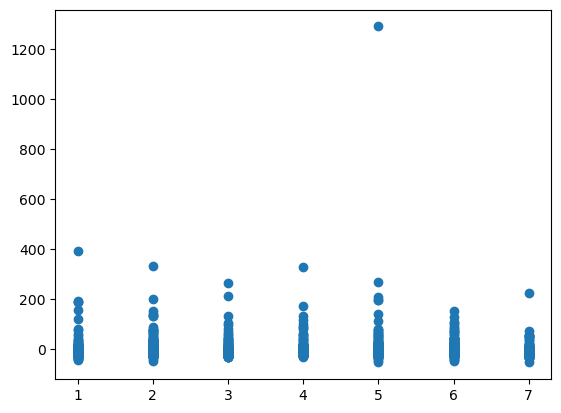

In [530]:
plt.scatter(df_flights_model['day_of_the_week'], df_flights_model['arr_delay'])
plt.show()

In [531]:
#dropping the outlier row
df_flights_model.drop(df_flights_model[df_flights_model['arr_delay'] == 
                                       df_flights_model['arr_delay'].max()].index, inplace=True)

In [632]:
df_flights_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1028 entries, 0 to 1028
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   day_of_the_week         1028 non-null   int64  
 1   Month                   1028 non-null   int64  
 2   arr_delay               1028 non-null   int64  
 3   distance                1028 non-null   int64  
 4   origin_tempC            1028 non-null   int64  
 5   origin_windspeedMiles   1028 non-null   int64  
 6   origin_WindGustMiles    1028 non-null   int64  
 7   origin_WindChillC       1028 non-null   int64  
 8   origin_precipInches     1028 non-null   float64
 9   origin_humidity         1028 non-null   int64  
 10  origin_visibilityMiles  1028 non-null   int64  
 11  origin_pressureInches   1028 non-null   int64  
 12  origin_DewPointC        1028 non-null   int64  
 13  origin_cloudcover       1028 non-null   int64  
 14  origin_uvIndex          1028 non-null   

In [532]:
#scale the numeric variables.
from sklearn.preprocessing import StandardScaler
# apply StandardScaler to the DataFrame
scaler = StandardScaler()
df_flights_scaled = scaler.fit_transform(df_flights_model)
# convert the scaled DataFrame back to a pandas DataFrame
df_flights_scaled = pd.DataFrame(df_flights_scaled, 
                                         columns=df_flights_model.columns)

In [533]:
#extract the target variable in separate dataframe
df_flights_target = df_flights_scaled['arr_delay']

#drop the target variable from the features dataset
df_flights_scaled.drop(columns=['arr_delay'], inplace=True)

In [ ]:
Performing PCA dimensionality reduction analysis

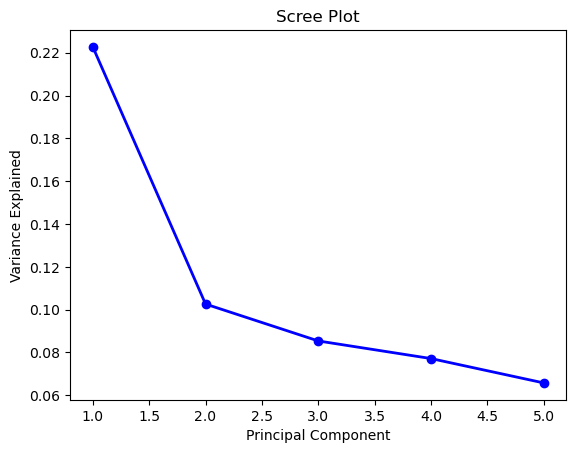

individual variance components:  [0.22273549 0.10259246 0.08535926 0.07713395 0.06574917]
cumulative variance components:  0.553570321099759


In [538]:
#perform PCA dimensionality reduction exercise. check for the important features
#as per PCA.

from sklearn.vdecomposition import PCA

#begin with 5 components
pca = PCA(n_components=5)

df_flights_pca = pca.fit_transform(df_flights_scaled)

#plot scree plot to understand the relative importance of each PCA component
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print("individual variance components: ", pca.explained_variance_ratio_)
print("cumulative variance components: ", np.sum(pca.explained_variance_ratio_))

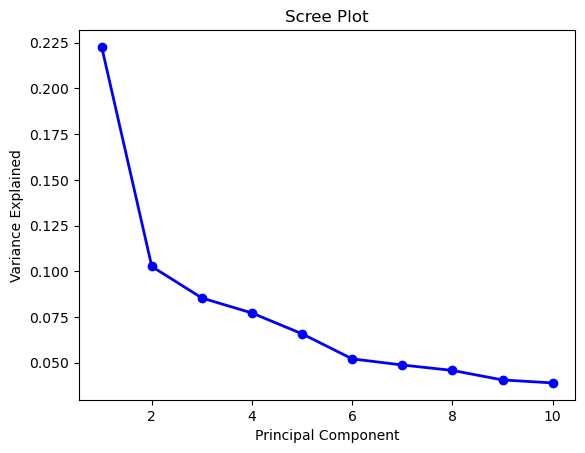

cumulative variance components:  0.7794470355655345


In [539]:
#PCA dimensionality reduction
from sklearn.decomposition import PCA

#try 10 components
pca = PCA(n_components=10)

df_flights_pca = pca.fit_transform(df_flights_scaled)

#plot scree plot to understand the relative importance of each PCA component
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print("cumulative variance components: ", np.sum(pca.explained_variance_ratio_))

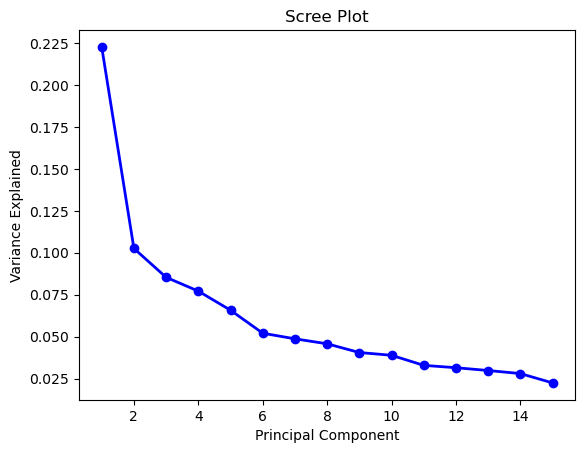

cumulative variance components:  0.9239605276680356


In [541]:
#PCA dimensionality reduction
from sklearn.decomposition import PCA

#50 components
pca = PCA(n_components=15)

df_flights_pca = pca.fit_transform(df_flights_scaled)

#plot scree plot to understand the relative importance of each PCA component
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

print("cumulative variance components: ", np.sum(pca.explained_variance_ratio_))

In [542]:
# list the important features as per PCA analysis
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

features = df_flights_scaled.columns

most_important_names = [features[most_important[i]] for i in range(n_pcs)]

dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df_most_important_features = pd.DataFrame(dic.items(), columns=['PCA','feature'])

df_most_important_features.to_csv("PCA_most_important_features.csv", index=False)

In [543]:
df_most_important_features

,PCA,feature
0,PC0,dest_WindChillC
1,PC1,origin_humidity
2,PC2,dest_humidity
3,PC3,dest_WindGustMiles
4,PC4,origin_windspeedMiles
5,PC5,origin_DewPointC
6,PC6,origin_pressureInches
7,PC7,origin_precipInches
8,PC8,day_of_the_week
9,PC9,distance


### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

In [ ]:
Fit Linear Regression Modeling

In [ ]:
#extract train and test for linear regression
from sklearn.model_selection import train_test_split

X = df_flights_scaled.values
y = df_flights_target.values

features = list(df_flights_scaled.iloc[:,:].columns)


# assuming X and y are your feature matrix and target variable, respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
#perform linear regression and fit the model. study the results and features
#statistical significance
import statsmodels.api as sm

# add a constant to the X variable
#X_train = sm.add_constant(X_train)

# create the OLS model
model = sm.OLS(y_train, X_train)

# fit the model
results = model.fit()

results.summary(xname=features)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.038
Model:                            OLS   Adj. R-squared (uncentered):              0.008
Method:                 Least Squares   F-statistic:                              1.271
Date:                Fri, 24 Feb 2023   Prob (F-statistic):                       0.170
Time:                        01:36:41   Log-Likelihood:                         -1092.0
No. Observations:                 822   AIC:                                      2234.
Df Residuals:                     797   BIC:                                      2352.
Df Model:                          25                                                  
Covariance Type:            nonrobust                                                  
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
day_of_the_week           -0.0225      0.034     -0.653      0.514      -0.090       0.045
Month                     -0.0384      0.036     -1.067      0.286      -0.109       0.032
distance                  -0.0112      0.033     -0.336      0.737      -0.077       0.054
origin_tempC               0.8831      0.447      1.975      0.049       0.005       1.761
origin_windspeedMiles      0.1057      0.093      1.137      0.256      -0.077       0.288
origin_WindGustMiles      -0.1164      0.093     -1.251      0.211      -0.299       0.066
origin_WindChillC         -0.8678      0.426     -2.035      0.042      -1.705      -0.031
origin_precipInches       -0.0314      0.040     -0.790      0.430      -0.110       0.047
origin_humidity           -0.0106      0.119     -0.089      0.929      -0.243       0.222
origin_visibilityMiles    -0.0670      0.040     -1.693      0.091      -0.145       0.011
origin_pressureInches      0.0553      0.038      1.438      0.151      -0.020       0.131
origin_DewPointC           0.0131      0.185      0.070      0.944      -0.351       0.377
origin_cloudcover         -0.0488      0.043     -1.145      0.252      -0.133       0.035
origin_uvIndex            -0.0011      0.050     -0.022      0.983      -0.100       0.098
dest_tempC                -0.0277      0.480     -0.058      0.954      -0.969       0.914
dest_windspeedMiles        0.0426      0.088      0.482      0.630      -0.131       0.216
dest_WindGustMiles        -0.0173      0.086     -0.201      0.841      -0.187       0.152
dest_WindChillC            0.0119      0.470      0.025      0.980      -0.910       0.934
dest_precipInches          0.0085      0.035      0.242      0.809      -0.060       0.077
dest_humidity              0.0812      0.111      0.734      0.463      -0.136       0.298
dest_visibilityMiles      -0.0019      0.039     -0.050      0.960      -0.079       0.075
dest_pressureInches        0.0471      0.036      1.309      0.191      -0.024       0.118
dest_DewPointC            -0.0260      0.192     -0.136      0.892      -0.403       0.351
dest_cloudcover            0.0004      0.041      0.009      0.993      -0.081       0.081
dest_uvIndex              -0.0334      0.045     -0.742      0.459      -0.122       0.055
==============================================================================
Omnibus:                      634.776   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11806.089
Skew:                           3.407   Prob(JB):                         0.00
Kurtosis:                      20.271   Cond. No.                         50.5
=========================================

In [ ]:
Fit XGBOOST Modeling

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [545]:
X = df_flights_scaled
Y = df_flights_target

estimator = XGBRegressor(objective= 'reg:squarederror')

parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 20),
    'learning_rate': np.arange(0.01, 0.2, 0.02),
    'random_state': [42]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    n_jobs = 10,
    cv = 5
)

grid_search.fit(X, Y)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': array([0.01, 0.03, 0.05, 0.07, 0.09, 0.11, 0.13, 0.15, 0.17, 0.19]),
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 20),
                         'random_state': [42]})

In [546]:
grid_search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.01, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=2, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=160, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [547]:
grid_search.best_params_

{'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 160,
 'random_state': 42}

In [548]:
grid_search.best_index_

5

In [549]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.iloc[5]

mean_fit_time                                                   0.090774
std_fit_time                                                    0.010217
mean_score_time                                                 0.002183
std_score_time                                                  0.001153
param_learning_rate                                                 0.01
param_max_depth                                                        2
param_n_estimators                                                   160
param_random_state                                                    42
params                 {'learning_rate': 0.01, 'max_depth': 2, 'n_est...
split0_test_score                                              -0.173297
split1_test_score                                               0.069418
split2_test_score                                               0.001576
split3_test_score                                               -0.04251
split4_test_score                                  

In [550]:
grid_search.n_features_in_

25

In [ ]:
Predicting the results on training data to cross check performance

In [612]:
Y_pred = grid_search.predict(X)
df_Y_pred = pd.DataFrame(Y_pred, columns=['pred_arr_delay'])
df_Y_pred = pd.concat([X, Y, df_Y_pred], axis=1)
df_Y_pred_show = df_Y_pred.iloc[:,-2:]
df_Y_pred_show

,arr_delay,pred_arr_delay
0,-0.182430,0.071235
1,-0.327959,0.082862
2,-0.958583,0.086205
3,3.334515,0.160331
4,-0.667526,0.086205
...,...,...
1023,0.763507,0.086205
1024,-0.473488,0.050581
1025,-0.109666,0.065551
1026,-0.619016,0.176074


In [616]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_flights_model['arr_delay'].array.reshape(-1,1))

StandardScaler()

In [618]:
Y_pred_inverse = scaler.inverse_transform(df_Y_pred_show)
df_Y_pred_inverse = pd.DataFrame(Y_pred_inverse, columns=['original_arrival_delay',
                                                          'predicted_arrival_delay'])
df_Y_pred_inverse

,original_arrival_delay,predicted_arrival_delay
0,-2.0,8.458343
1,-8.0,8.937708
2,-34.0,9.075533
3,143.0,12.131696
4,-22.0,9.075533
...,...,...
1023,37.0,9.075533
1024,-14.0,7.606805
1025,1.0,8.223992
1026,-20.0,12.780767


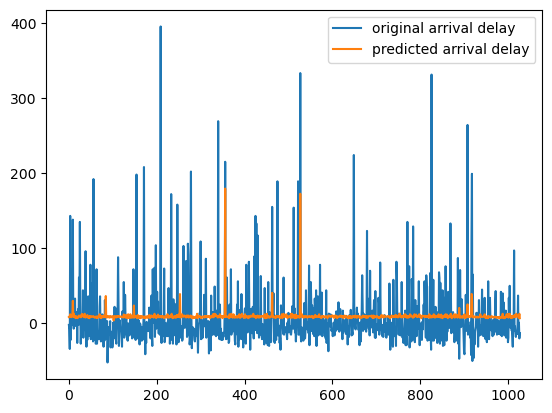

In [628]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

line1, = ax.plot(df_Y_pred_inverse['original_arrival_delay'], label='original arrival delay')
line2, = ax.plot(df_Y_pred_inverse['predicted_arrival_delay'], label='predicted arrival delay')
ax.legend()

plt.show()

In [ ]:
The prediction of delay on training data is off the mark as the model is a poor fit.

In [ ]:
Predicting on the actual test data

In [597]:
Z = pd.read_csv("flights_scaled_test_data.csv")
df = pd.read_csv("flights_db_test_data.csv")

In [ ]:
Z_pred = grid_search.predict(Z)

In [590]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(df_flights_model['arr_delay'].array.reshape(-1,1))

StandardScaler()

In [ ]:
Z_pred_inverse = scaler.inverse_transform(Z_pred.reshape(-1,1))

In [599]:
df_Z_pred_inverse = pd.DataFrame(Z_pred_inverse, columns=['predicted_arrival_delay'])
df_submission = df[['fl_date', 'mkt_unique_carrier', 'mkt_carrier_fl_num',
                                                                'origin','dest']]

In [ ]:
df_submission = pd.concat([df_submission, df_Z_pred_inverse], axis=1)

In [601]:
df_submission.to_csv("project submission.csv", index=False)

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.